In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import ast
import scipy
import mdtraj as md
from typing import Dict, Tuple
import os
from sklearn.linear_model import LinearRegression
import sys
import pyblock
import gzip
import pickle

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 150,                   # medium resolution

    # Axes
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

def find_xtc_filenames(path_to_dir, suffix=".xtc"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

# --- Utility functions ---
def RMSE(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.sqrt(np.mean((actual - predicted)**2))

# Function to calculate helical fraction
def helical_fraction(ss_line):
    helix_chars = {'H', 'G', 'I'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate per-residue helicity per frame
def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

# functions for analysis of chemical shifts
# functions for chemical shift analysis
# Constants
# from here : https://link.springer.com/article/10.1007/s10858-010-9433-9 (average prediction error of the forward model)
CS_UNCERTAINTIES = {
    "Sparta+": {"C": 1.09, "CA": 0.94, "CB": 1.14, "N": 2.45, "H": 0.49, "HA": 0.25}
}

POTENCI_UNCERTAINTIES = {"C": 0.1861, "CA": 0.1862, "CB": 0.1677, "N": 0.5341, "H": 0.0735, "HA": 0.0319, "HB": 0.0187}

AA_dict = {
    "A": "ALA",  # Alanine
    "R": "ARG",  # Arginine
    "N": "ASN",  # Asparagine
    "D": "ASP",  # Aspartic Acid
    "C": "CYS",  # Cysteine
    "E": "GLU",  # Glutamic Acid
    "Q": "GLN",  # Glutamine
    "G": "GLY",  # Glycine
    "H": "HIS",  # Histidine
    "I": "ILE",  # Isoleucine
    "L": "LEU",  # Leucine
    "K": "LYS",  # Lysine
    "M": "MET",  # Methionine
    "F": "PHE",  # Phenylalanine
    "P": "PRO",  # Proline
    "S": "SER",  # Serine
    "T": "THR",  # Threonine
    "W": "TRP",  # Tryptophan
    "Y": "TYR",  # Tyrosine
    "V": "VAL",  # Valine
}

# atom types to use during reweighting: choose from [ HA CA HN N C CB ]
ATOM_TYPES = ["CA", "HA", "CB", "HN", "N", "C", "H"] # HN and H present because "H" is used in potenci shift tables
ATOM_TYPES = ["CA"] 

def load_experimental_shifts(path: str, ATOM_TYPES) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#RESID'][i])
        for col in df.columns[2:]:
            if col in ATOM_TYPES: # only including specified nuclei
                if col=='HN':
                    try:
                        value = float(df[col][i])
                        if value>0:
                            residues.append(res)
                            names.append('H') # rename HN to H
                            values.append(value)
                    except:
                        continue
                else:
                    try:
                        value = float(df[col][i])
                        if value>0:
                            residues.append(res)
                            names.append(col)
                            values.append(value)
                    except:
                        continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_and_filter_experimental_shifts(path: str, bmrb_stats_path: str, sigma_cutoff = 3.0, ATOM_TYPES = ATOM_TYPES) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    bmrb = pd.read_csv(bmrb_stats_path)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#RESID'][i])
        resname = str(df['RESNAME'][i])
        if len(resname)==1:
            resname = AA_dict[resname] # convert to 3-letter code if 1-letter
        for col in df.columns[2:]:
            if col in ATOM_TYPES: # only including specified nuclei
                try:
                    value = float(df[col][i])
                    if value>0:
                        # extract bmrb avg and sd
                        if col=='HN':
                            row = bmrb[(bmrb["comp_id"] == resname) & (bmrb["atom_id"] == 'H')]
                            bmrb_mu = row["avg"].values[0]
                            bmrb_sd = row["std"].values[0]
                            if np.abs(value - bmrb_mu) < bmrb_sd * sigma_cutoff:
                                residues.append(res)
                                names.append('H') # rename HN to H
                                values.append(value)
                        else:
                            row = bmrb[(bmrb["comp_id"] == resname) & (bmrb["atom_id"] == col)]
                            bmrb_mu = row["avg"].values[0]
                            bmrb_sd = row["std"].values[0]
                            if np.abs(value - bmrb_mu) < bmrb_sd * sigma_cutoff:
                                residues.append(res)
                                names.append(col)
                                values.append(value)
                except:
                    continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_potenci_shifts(path: str, ATOM_TYPES = ATOM_TYPES) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#NUM'][i])
        for col in df.columns[2:]:
            if col in ATOM_TYPES: # only including specified nuclei
                try:
                    value = float(df[col][i])
                    if value>0:
                        residues.append(res)
                        names.append(col)
                        values.append(value)
                except:
                    continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_generated_shifts(path: str) -> pd.DataFrame:
    """
    Load generated shifts from a CSV file.
    Assumes columns: resSeq, name, 0, 1, 2, ..., representing one residue/atom per row and frames across columns.
    Returns DataFrame indexed by (resSeq, name), with frames as columns.
    """
    df = pd.read_csv(path)
    df["resSeq"] = df["resSeq"].astype(int)
    df["name"] = df["name"].astype(str)
    df.set_index(["resSeq", "name"], inplace=True)
    return df

def standardize_deltas(gen_df: pd.DataFrame, exp_dict: Dict[Tuple[int, str], float],
                       predictor: str = "Sparta+", avg_gscore: float = None) -> Tuple[np.ndarray, list]:
    cs_uncertainties = CS_UNCERTAINTIES[predictor]
    keys = sorted(set(exp_dict).intersection(set(gen_df.index)))

    if avg_gscore is None:
        std_devs = np.array([cs_uncertainties[a] for (_, a) in keys]).reshape(-1, 1)
    else:
        std_devs = np.array([
            POTENCI_UNCERTAINTIES[a] + ( cs_uncertainties[a] - POTENCI_UNCERTAINTIES[a] ) * (1 - avg_gscore)
            for r, a in keys
        ]).reshape(-1, 1)
    
    exp_vals = np.array([exp_dict[k] for k in keys]).reshape(-1, 1)
    gen_vals = gen_df.loc[keys].values  # shape: (n_obs, n_frames)
    std_delta = (gen_vals - exp_vals) / std_devs
    return std_delta, keys, exp_vals, gen_vals, std_devs

# function to calculate the difference between experiment and simulation: CALC - EXP
def raw_diff(gen_df: pd.DataFrame, exp_dict: Dict[Tuple[int, str], float]):
    keys = sorted(set(exp_dict).intersection(set(gen_df.index)))
    exp_vals = np.array([exp_dict[k] for k in keys]).reshape(-1, 1)
    gen_vals = gen_df.loc[keys].values  # shape: (n_obs, n_frames)
    diff = gen_vals - exp_vals

    return diff, keys

def get_RMSE_cs(
    std_delta_cs: np.ndarray,  # shape (n_obs, n_samples)
    weights: np.ndarray = None,  # shape (n_samples,)
    order: int = 2,  # order of the norm
) -> float:
    """Root Mean Square Error."""
    assert len(std_delta_cs.shape) == 2
    mask_nan = ~np.isnan(std_delta_cs).any(axis=0)
    if weights is None:
        return np.linalg.norm(np.average(std_delta_cs[:, mask_nan], axis=1), ord=order) / np.power(
            len(std_delta_cs),
            1 / order,
        )
    mask_nan_weights = ~np.isnan(weights)
    if weights[mask_nan_weights & (~mask_nan)].sum() != 0:
        print("+++ WARNING: samples with NaN chemical shifts should have 0 weight")
    mask_nan = mask_nan & mask_nan_weights
    if not mask_nan.any():  # this happens if the optimization failed
        return np.nan
    return np.linalg.norm(
        np.average(std_delta_cs[:, mask_nan], weights=weights[mask_nan], axis=1),
        ord=order,
    ) / np.power(len(std_delta_cs), 1 / order)

path = '../'

#####################
### EXAMPLE USAGE ###
#####################


#gen_df = load_generated_shifts(predfile)
#exp_dict = load_and_filter_experimental_shifts(expfile, bmrb_stats_path=bmrb_stats_path)

#std_delta_cs, keys = standardize_deltas(gen_df, exp_dict, predictor = CS_predictor)
#print(std_delta_cs.shape)
#print(get_RMSE(std_delta_cs))
#print(get_RMSE(std_delta_cs[:, ~np.isnan(weights_nan)]))
#print(get_RMSE(std_delta_cs, weights=np.repeat(1, std_delta_cs.shape[1])))


data_path='../Ensemble_reweighting/'


18


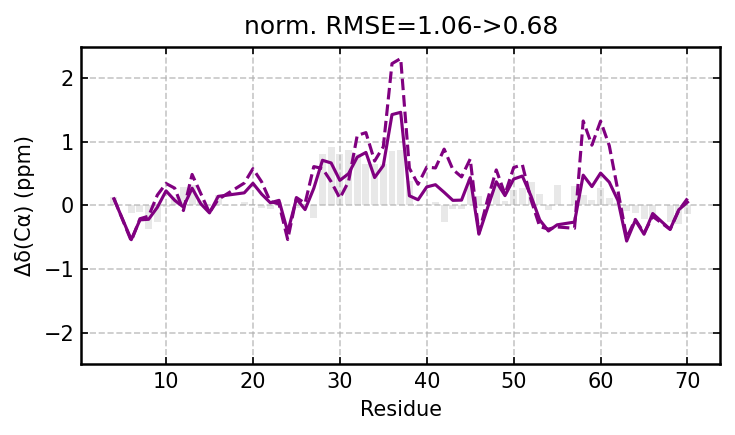

In [4]:
protein = 'ACTR_OPES_310K_ensemble'

# reweighting directory
rew_dir = 'opes_rew_cs_pre/'
tc = 5.0 # tauc value used

# Load data
wopt_array = np.load(data_path+rew_dir+f'rew_wopt_array{tc}ns.npy')
neffs = np.loadtxt(data_path+rew_dir+f'rew_neffs{tc}ns.txt')
# Find the last index where neffs > 0.2
idx_opt = np.where(neffs > 0.2)[0][-1]
print(idx_opt)
# PRE frames
PREframes = np.loadtxt(data_path+rew_dir+"PREframes.txt").astype(int)
prior_weights = np.ones(wopt_array[0].shape[0])/wopt_array[0].shape
#prior_weights = np.loadtxt(protein+"/weights_310K.txt")[PREframes]

nucleus='CA'
all_types = ['CA', 'CB', 'HA', 'C', 'H', 'HN', 'N']

label_dict = {'CA': 'Cα', 'HA': 'Hα', 'CB': 'Cβ', 'C': "C'"}
axlim_dict = {'CA': 2.5, 'HA': 1, 'CB': 2.5, 'C': 2.5}

traj_names = np.sort(find_xtc_filenames(f'./{protein}/'))

# load CS data
for i in range(len(traj_names)):
    if i==0:
        gen_df = load_generated_shifts(data_path+f'./{protein}/CS/CS_{traj_names[i][:-4]}.csv')
    else:
        tmp_df = load_generated_shifts(data_path+f'./{protein}/CS/CS_{traj_names[i][:-4]}.csv')
        gen_df= pd.concat([gen_df, tmp_df], axis=1, join = 'outer', ignore_index=True)

# experimental CS data
exp_dict = load_and_filter_experimental_shifts(data_path+f'./exp_data_ACTR/CS.dat', data_path+'./exp_data_ACTR/cs_stat_aa_filt.csv', ATOM_TYPES=all_types)

# average gscore for CS error scaling
gscores = np.array(pd.read_csv(data_path+'exp_data_ACTR/ACTR_adopt2_gscores.csv')['g_score'])
avg_gscore = np.mean(gscores[~np.isnan(gscores)])

# get standardised deltas
std_delta_cs, keys, expCS, calcCS, expCS_err = standardize_deltas(gen_df, exp_dict, predictor = 'Sparta+', avg_gscore=avg_gscore)
std_delta_cs = std_delta_cs[:,PREframes]

# load RC shifts
potenci = load_potenci_shifts(data_path+f'potenci/ACTR_RCshifts.dat', ATOM_TYPES=all_types)

# calculate experimental secondary shifts
potenci_residues = []
potenci_shifts = []
for key in list(potenci.keys()):
    if key[1]==nucleus:
        potenci_residues.append(key[0])
        potenci_shifts.append(potenci[key])

exp_residues = []
exp_shifts = []
for key in list(exp_dict.keys()):
    if key[1]==nucleus:
        exp_residues.append(key[0])
        exp_shifts.append(exp_dict[key])

potenci_residues = np.array(potenci_residues)
potenci_shifts = np.array(potenci_shifts)
exp_residues = np.array(exp_residues)
exp_shifts = np.array(exp_shifts)

common_residues = np.intersect1d(potenci_residues, exp_residues)
indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
indices_e = np.where(np.isin(exp_residues, common_residues))[0]
SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

# calculated secondary shifts from models (before/after reweighting)
calc_vals = []
calc_residues = []
for res in common_residues:
    try:
        calc_vals.append(list(gen_df.loc[res, nucleus]))
        calc_residues.append(res)
    except KeyError:
        continue

calc_residues = np.array(calc_residues)
calc_vals = np.array(calc_vals).T
calc_vals = calc_vals[PREframes]

# Average prior
prior = np.average(calc_vals, axis=0, weights=prior_weights)  
# Align Potenci shifts with calc_residues
indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
potenci_for_calc = potenci_shifts[indices_p2]
# Now compute secondary shifts
SSprior = prior - potenci_for_calc
CS_RMSE_prior = get_RMSE_cs(std_delta_cs, weights=prior_weights)
armse = np.sqrt(np.mean((SSexp-SSprior)**2))

# Average posterior
post = np.average(calc_vals, axis=0, weights=wopt_array[idx_opt])  
# Align Potenci shifts with calc_residues
indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
potenci_for_calc = potenci_shifts[indices_p2]
# Now compute secondary shifts
SSpost = post - potenci_for_calc
CS_RMSE_post = get_RMSE_cs(std_delta_cs, weights=wopt_array[idx_opt])
armse = np.sqrt(np.mean((SSexp-SSpost)**2))

# --- Plot 4: secondary CA shifts exp vs calculated prior and posterior ---

plt.figure(figsize = (5, 3))

# prior and posterior RMSE
plt.title(f"norm. RMSE={CS_RMSE_prior:.2f}->{CS_RMSE_post:.2f}")

# experimental values
plt.bar(exp_residues[indices_e], SSexp, color = 'lightgrey', alpha=0.5, label='Exp.')
plt.ylim(-axlim_dict[nucleus],axlim_dict[nucleus])
plt.xlabel("Residue"); plt.ylabel(f"Δδ({label_dict[nucleus]}) (ppm)")


plt.plot(calc_residues, SSprior, color="purple", label="Prior", linewidth=1.5, linestyle='dashed')
plt.plot(calc_residues, SSpost, color="purple", label="Posterior", linewidth=1.5)

plt.tight_layout()
plt.savefig(data_path+rew_dir+f"{nucleus}_CS_prior_post.pdf")



18


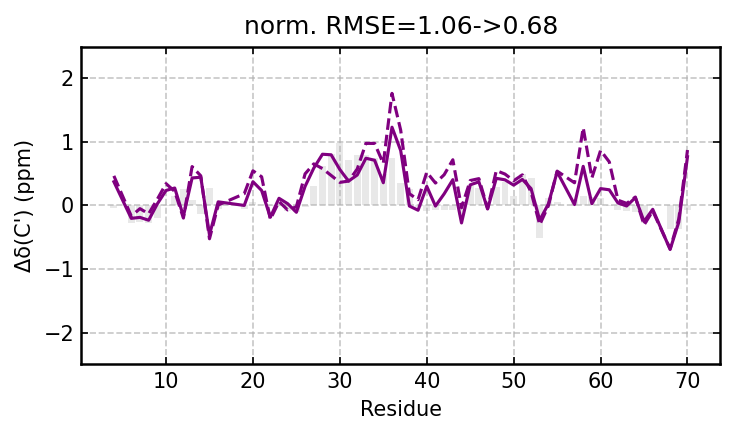

In [5]:
protein = 'ACTR_OPES_310K_ensemble'

# reweighting directory
rew_dir = 'opes_rew_cs_pre/'
tc = 5.0 # tauc value used

# Load data
wopt_array = np.load(data_path+rew_dir+f'rew_wopt_array{tc}ns.npy')
neffs = np.loadtxt(data_path+rew_dir+f'rew_neffs{tc}ns.txt')
# Find the last index where neffs > 0.2
idx_opt = np.where(neffs > 0.2)[0][-1]
print(idx_opt)
# PRE frames
PREframes = np.loadtxt(data_path+rew_dir+"PREframes.txt").astype(int)
prior_weights = np.ones(wopt_array[0].shape[0])/wopt_array[0].shape
#prior_weights = np.loadtxt(protein+"/weights_310K.txt")[PREframes]

nucleus='C'
all_types = ['CA', 'CB', 'HA', 'C', 'H', 'HN', 'N']

label_dict = {'CA': 'Cα', 'HA': 'Hα', 'CB': 'Cβ', 'C': "C'"}
axlim_dict = {'CA': 2.5, 'HA': 1, 'CB': 2.5, 'C': 2.5}

traj_names = np.sort(find_xtc_filenames(f'./{protein}/'))

# load CS data
for i in range(len(traj_names)):
    if i==0:
        gen_df = load_generated_shifts(data_path+f'./{protein}/CS/CS_{traj_names[i][:-4]}.csv')
    else:
        tmp_df = load_generated_shifts(data_path+f'./{protein}/CS/CS_{traj_names[i][:-4]}.csv')
        gen_df= pd.concat([gen_df, tmp_df], axis=1, join = 'outer', ignore_index=True)

# experimental CS data
exp_dict = load_and_filter_experimental_shifts(data_path+f'./exp_data_ACTR/CS.dat', data_path+'./exp_data_ACTR/cs_stat_aa_filt.csv', ATOM_TYPES=all_types)

# average gscore for CS error scaling
gscores = np.array(pd.read_csv(data_path+'exp_data_ACTR/ACTR_adopt2_gscores.csv')['g_score'])
avg_gscore = np.mean(gscores[~np.isnan(gscores)])

# get standardised deltas
std_delta_cs, keys, expCS, calcCS, expCS_err = standardize_deltas(gen_df, exp_dict, predictor = 'Sparta+', avg_gscore=avg_gscore)
std_delta_cs = std_delta_cs[:,PREframes]

# load RC shifts
potenci = load_potenci_shifts(data_path+f'potenci/ACTR_RCshifts.dat', ATOM_TYPES=all_types)

# calculate experimental secondary shifts
potenci_residues = []
potenci_shifts = []
for key in list(potenci.keys()):
    if key[1]==nucleus:
        potenci_residues.append(key[0])
        potenci_shifts.append(potenci[key])

exp_residues = []
exp_shifts = []
for key in list(exp_dict.keys()):
    if key[1]==nucleus:
        exp_residues.append(key[0])
        exp_shifts.append(exp_dict[key])

potenci_residues = np.array(potenci_residues)
potenci_shifts = np.array(potenci_shifts)
exp_residues = np.array(exp_residues)
exp_shifts = np.array(exp_shifts)

common_residues = np.intersect1d(potenci_residues, exp_residues)
indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
indices_e = np.where(np.isin(exp_residues, common_residues))[0]
SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

# calculated secondary shifts from models (before/after reweighting)
calc_vals = []
calc_residues = []
for res in common_residues:
    try:
        calc_vals.append(list(gen_df.loc[res, nucleus]))
        calc_residues.append(res)
    except KeyError:
        continue

calc_residues = np.array(calc_residues)
calc_vals = np.array(calc_vals).T
calc_vals = calc_vals[PREframes]

# Average prior
prior = np.average(calc_vals, axis=0, weights=prior_weights)  
# Align Potenci shifts with calc_residues
indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
potenci_for_calc = potenci_shifts[indices_p2]
# Now compute secondary shifts
SSprior = prior - potenci_for_calc
CS_RMSE_prior = get_RMSE_cs(std_delta_cs, weights=prior_weights)
armse = np.sqrt(np.mean((SSexp-SSprior)**2))

# Average posterior
post = np.average(calc_vals, axis=0, weights=wopt_array[idx_opt])  
# Align Potenci shifts with calc_residues
indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
potenci_for_calc = potenci_shifts[indices_p2]
# Now compute secondary shifts
SSpost = post - potenci_for_calc
CS_RMSE_post = get_RMSE_cs(std_delta_cs, weights=wopt_array[idx_opt])
armse = np.sqrt(np.mean((SSexp-SSpost)**2))

# --- Plot 4: secondary CA shifts exp vs calculated prior and posterior ---

plt.figure(figsize = (5, 3))

# prior and posterior RMSE
plt.title(f"norm. RMSE={CS_RMSE_prior:.2f}->{CS_RMSE_post:.2f}")

# experimental values
plt.bar(exp_residues[indices_e], SSexp, color = 'lightgrey', alpha=0.5, label='Exp.')
plt.ylim(-axlim_dict[nucleus],axlim_dict[nucleus])
plt.xlabel("Residue"); plt.ylabel(f"Δδ({label_dict[nucleus]}) (ppm)")


plt.plot(calc_residues, SSprior, color="purple", label="Prior", linewidth=1.5, linestyle='dashed')
plt.plot(calc_residues, SSpost, color="purple", label="Posterior", linewidth=1.5)

plt.tight_layout()
plt.savefig(data_path+rew_dir+f"{nucleus}_CS_prior_post.pdf")



18


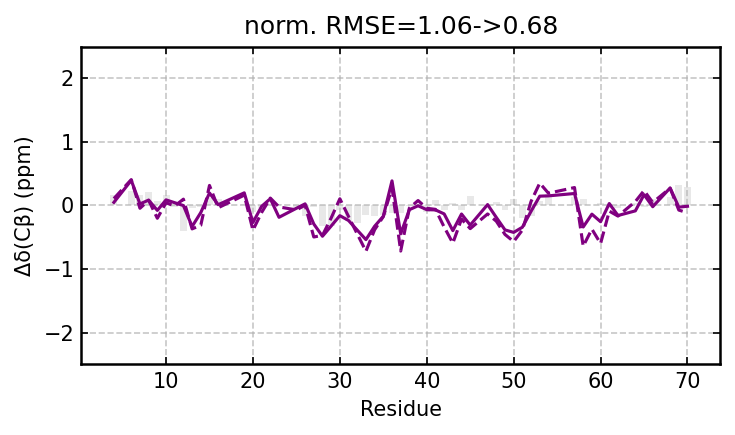

In [6]:
protein = 'ACTR_OPES_310K_ensemble'

# reweighting directory
rew_dir = 'opes_rew_cs_pre/'
tc = 5.0 # tauc value used

# Load data
wopt_array = np.load(data_path+rew_dir+f'rew_wopt_array{tc}ns.npy')
neffs = np.loadtxt(data_path+rew_dir+f'rew_neffs{tc}ns.txt')
# Find the last index where neffs > 0.2
idx_opt = np.where(neffs > 0.2)[0][-1]
print(idx_opt)
# PRE frames
PREframes = np.loadtxt(data_path+rew_dir+"PREframes.txt").astype(int)
prior_weights = np.ones(wopt_array[0].shape[0])/wopt_array[0].shape
#prior_weights = np.loadtxt(protein+"/weights_310K.txt")[PREframes]

nucleus='CB'
all_types = ['CA', 'CB', 'HA', 'C', 'H', 'HN', 'N']

label_dict = {'CA': 'Cα', 'HA': 'Hα', 'CB': 'Cβ', 'C': "C'"}
axlim_dict = {'CA': 2.5, 'HA': 1, 'CB': 2.5, 'C': 2.5}

traj_names = np.sort(find_xtc_filenames(f'./{protein}/'))

# load CS data
for i in range(len(traj_names)):
    if i==0:
        gen_df = load_generated_shifts(data_path+f'./{protein}/CS/CS_{traj_names[i][:-4]}.csv')
    else:
        tmp_df = load_generated_shifts(data_path+f'./{protein}/CS/CS_{traj_names[i][:-4]}.csv')
        gen_df= pd.concat([gen_df, tmp_df], axis=1, join = 'outer', ignore_index=True)

# experimental CS data
exp_dict = load_and_filter_experimental_shifts(data_path+f'./exp_data_ACTR/CS.dat', data_path+'./exp_data_ACTR/cs_stat_aa_filt.csv', ATOM_TYPES=all_types)

# average gscore for CS error scaling
gscores = np.array(pd.read_csv(data_path+'exp_data_ACTR/ACTR_adopt2_gscores.csv')['g_score'])
avg_gscore = np.mean(gscores[~np.isnan(gscores)])

# get standardised deltas
std_delta_cs, keys, expCS, calcCS, expCS_err = standardize_deltas(gen_df, exp_dict, predictor = 'Sparta+', avg_gscore=avg_gscore)
std_delta_cs = std_delta_cs[:,PREframes]

# load RC shifts
potenci = load_potenci_shifts(data_path+f'potenci/ACTR_RCshifts.dat', ATOM_TYPES=all_types)

# calculate experimental secondary shifts
potenci_residues = []
potenci_shifts = []
for key in list(potenci.keys()):
    if key[1]==nucleus:
        potenci_residues.append(key[0])
        potenci_shifts.append(potenci[key])

exp_residues = []
exp_shifts = []
for key in list(exp_dict.keys()):
    if key[1]==nucleus:
        exp_residues.append(key[0])
        exp_shifts.append(exp_dict[key])

potenci_residues = np.array(potenci_residues)
potenci_shifts = np.array(potenci_shifts)
exp_residues = np.array(exp_residues)
exp_shifts = np.array(exp_shifts)

common_residues = np.intersect1d(potenci_residues, exp_residues)
indices_p = np.where(np.isin(potenci_residues, common_residues))[0]
indices_e = np.where(np.isin(exp_residues, common_residues))[0]
SSexp = exp_shifts[indices_e] - potenci_shifts[indices_p]

# calculated secondary shifts from models (before/after reweighting)
calc_vals = []
calc_residues = []
for res in common_residues:
    try:
        calc_vals.append(list(gen_df.loc[res, nucleus]))
        calc_residues.append(res)
    except KeyError:
        continue

calc_residues = np.array(calc_residues)
calc_vals = np.array(calc_vals).T
calc_vals = calc_vals[PREframes]

# Average prior
prior = np.average(calc_vals, axis=0, weights=prior_weights)  
# Align Potenci shifts with calc_residues
indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
potenci_for_calc = potenci_shifts[indices_p2]
# Now compute secondary shifts
SSprior = prior - potenci_for_calc
CS_RMSE_prior = get_RMSE_cs(std_delta_cs, weights=prior_weights)
armse = np.sqrt(np.mean((SSexp-SSprior)**2))

# Average posterior
post = np.average(calc_vals, axis=0, weights=wopt_array[idx_opt])  
# Align Potenci shifts with calc_residues
indices_p2 = np.where(np.isin(potenci_residues, calc_residues))[0]
potenci_for_calc = potenci_shifts[indices_p2]
# Now compute secondary shifts
SSpost = post - potenci_for_calc
CS_RMSE_post = get_RMSE_cs(std_delta_cs, weights=wopt_array[idx_opt])
armse = np.sqrt(np.mean((SSexp-SSpost)**2))

# --- Plot 4: secondary CA shifts exp vs calculated prior and posterior ---

plt.figure(figsize = (5, 3))

# prior and posterior RMSE
plt.title(f"norm. RMSE={CS_RMSE_prior:.2f}->{CS_RMSE_post:.2f}")

# experimental values
plt.bar(exp_residues[indices_e], SSexp, color = 'lightgrey', alpha=0.5, label='Exp.')
plt.ylim(-axlim_dict[nucleus],axlim_dict[nucleus])
plt.xlabel("Residue"); plt.ylabel(f"Δδ({label_dict[nucleus]}) (ppm)")


plt.plot(calc_residues, SSprior, color="purple", label="Prior", linewidth=1.5, linestyle='dashed')
plt.plot(calc_residues, SSpost, color="purple", label="Posterior", linewidth=1.5)

plt.tight_layout()
plt.savefig(data_path+rew_dir+f"{nucleus}_CS_prior_post.pdf")

